# Rock Paper Scissors CNN (100% Acc)

kresnaandika36@gmail.com<br>
github.com/kresnandika<br>

**This code is all my own with some references, feel free to use it**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile, os, shutil
import seaborn as sn

In [2]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from numba import cuda 
from tensorflow.keras.optimizers import Adam

!pip install ipython-autotime
%load_ext autotime

time: 209 µs (started: 2021-07-27 09:13:58 +00:00)


## Load pre-trained

In [3]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip

--2021-07-27 09:13:58--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip.9’

rockpaperscissors.z 100%[===================>] 307.92M  1.41MB/s    in 83s     

2021-07-27 09:15:22 (3.70 MB/s) - ‘rockpaperscissors.zip.9’ saved [322873683/322873683]

time: 1min 24s (started: 2021-07-27 09:13:58 +00:00)


In [4]:
local_zip = '/content/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


time: 5.17 s (started: 2021-07-27 09:15:23 +00:00)


## Making some folders & Split the data

In [5]:
base_dir = '/tmp/rockpaperscissors'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'val')
rock_dir = os.path.join(base_dir,'rock')
paper_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')

time: 3.12 ms (started: 2021-07-27 09:15:28 +00:00)


In [6]:
train_rock = os.path.join(train_dir, 'rock')
val_rock = os.path.join(validation_dir, 'rock')

train_paper = os.path.join(train_dir, 'paper')
val_paper = os.path.join(validation_dir, 'paper')

train_scissors = os.path.join(train_dir, 'scissors')
val_scissors = os.path.join(validation_dir, 'scissors')

time: 5.29 ms (started: 2021-07-27 09:15:28 +00:00)


In [7]:
list_directory=[train_dir,validation_dir,train_rock,val_rock,
                train_paper,val_paper,train_scissors,val_scissors]

try:
  for i in list_directory:
    os.mkdir(i)
except OSError:
  pass

time: 5.05 ms (started: 2021-07-27 09:15:28 +00:00)


In [8]:
train_rock_dir, val_rock_dir = train_test_split(os.listdir(rock_dir), test_size = 0.40)
train_paper_dir, val_paper_dir = train_test_split(os.listdir(paper_dir), test_size = 0.40)
train_scissors_dir, val_scissors_dir = train_test_split(os.listdir(scissors_dir), test_size = 0.40)

time: 10.6 ms (started: 2021-07-27 09:15:28 +00:00)


In [9]:
try :
  for file in train_rock_dir:
    shutil.copy(os.path.join(rock_dir, file), os.path.join(train_rock, file))
  for file in train_paper_dir:
    shutil.copy(os.path.join(paper_dir,file), os.path.join(train_paper,file))
  for file in train_scissors_dir:
    shutil.copy(os.path.join(scissors_dir,file), os.path.join(train_scissors,file))
  for file in val_rock_dir:
    shutil.copy(os.path.join(rock_dir, file), os.path.join(val_rock,file))
  for file in val_paper_dir:
    shutil.copy(os.path.join(paper_dir,file), os.path.join(val_paper,file))
  for file in val_scissors_dir:
    shutil.copy(os.path.join(scissors_dir,file), os.path.join(val_scissors,file))
except OSError:
  pass

time: 4.66 s (started: 2021-07-27 09:15:28 +00:00)


## Variabel Definition  & Base model

In [10]:
batch_size = 32 
num_classes = 3 
dropout = 0.5 
epochs = 30
lr = 0.001

time: 2.8 ms (started: 2021-07-27 09:15:32 +00:00)


In [11]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) # Atribuindo o método ao modelo e os pesos da imagenet
for layer in base_model.layers: 
    layer.trainable = False

time: 2.54 s (started: 2021-07-27 09:15:32 +00:00)


## Define Callback class

Model training will be stopped if its accuracy or loss is good enough

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=1.00):
      print("--> Callback: Reached 100% accuracy. That's perfect, Cheers! <--")
      self.model.stop_training = True

callbacks = myCallback()

time: 4.28 ms (started: 2021-07-27 09:15:35 +00:00)


## Defining the CNN Model

In [13]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))

time: 38.2 ms (started: 2021-07-27 09:15:35 +00:00)


## Continue Model with own layers

In [14]:
x = Flatten()(base_model.output) 
x = Dense(1024, activation='relu')(x)
x = Dropout(dropout)(x) 
x = Dense(num_classes, activation='softmax')(x)

time: 267 ms (started: 2021-07-27 09:15:35 +00:00)


## Compiling the model with its optimizer, loss function and metric

In [15]:
model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(lr=lr),loss='categorical_crossentropy',metrics=['accuracy'])

time: 50.2 ms (started: 2021-07-27 09:15:35 +00:00)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Applying Data Augmentation Techniques and  InceptionV3

For folders not organized in training and validation, it is possible to split. First use validation_split=0.4 and then in flow use subset="training/validation". Remember : **Never augment picture in validation.**

In [16]:
# object initialization with inceptionV3 + split data to 40%
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.4, preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

# train
train_generator = train_data_gen.flow_from_directory('../tmp/rockpaperscissors',
                                                 target_size=(150, 150),
                                                 batch_size=batch_size,
                                                 class_mode="categorical",
                                                 shuffle=False,
                                                 classes=['paper', 'rock', 'scissors'],
                                                 subset='training')

# validation
val_generator = train_data_gen.flow_from_directory('../tmp/rockpaperscissors',
                                                 target_size=(150, 150),
                                                 batch_size=16,
                                                 class_mode="categorical",
                                                 shuffle=False,
                                                 classes=['paper', 'rock', 'scissors'],
                                                 subset='validation')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.
time: 231 ms (started: 2021-07-27 09:15:35 +00:00)


## Run model with callback and validation split

In [17]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
step_size_train = train_generator.n//train_generator.batch_size
step_size_test = val_generator.n//val_generator.batch_size

history = model.fit(
        train_generator,
        steps_per_epoch=step_size_train,
        epochs=epochs,
        shuffle=True,
        validation_data=val_generator,
        callbacks=[callbacks],
        validation_steps=step_size_test)

Epoch 1/30
41/41 [==============================] - 74s 2s/step - loss: 43.3721 - accuracy: 0.6942 - val_loss: 1.8019 - val_accuracy: 0.8738
Epoch 2/30
41/41 [==============================] - 69s 2s/step - loss: 1.3764 - accuracy: 0.9150 - val_loss: 0.3741 - val_accuracy: 0.9722
Epoch 3/30
41/41 [==============================] - 69s 2s/step - loss: 0.2003 - accuracy: 0.9750 - val_loss: 0.1434 - val_accuracy: 0.9826
Epoch 4/30
41/41 [==============================] - 69s 2s/step - loss: 0.0757 - accuracy: 0.9836 - val_loss: 0.1542 - val_accuracy: 0.9838
Epoch 5/30
41/41 [==============================] - 69s 2s/step - loss: 0.0640 - accuracy: 0.9914 - val_loss: 0.0974 - val_accuracy: 0.9861
Epoch 6/30
41/41 [==============================] - 69s 2s/step - loss: 0.0281 - accuracy: 0.9939 - val_loss: 0.1021 - val_accuracy: 0.9861
Epoch 7/30
41/41 [==============================] - 69s 2s/step - loss: 0.0255 - accuracy: 0.9945 - val_loss: 0.0708 - val_accuracy: 0.9884
Epoch 8/30
41/41 [=

In [18]:
# Result model
results = model.evaluate_generator(val_generator, 437)
print('Acc: %.3f, Loss: %.3f' % (results[1], results[0]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Acc: 0.991, Loss: 0.053
time: 53.5 s (started: 2021-07-27 09:32:10 +00:00)


## Plot loss, Accuracy, Classification report and Confusion Matrix

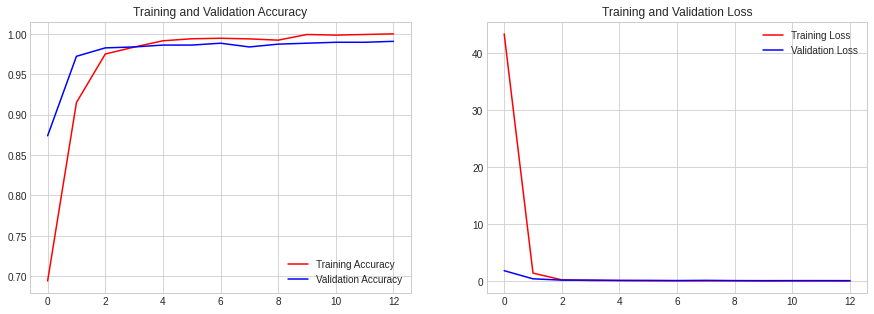

time: 446 ms (started: 2021-07-27 09:33:04 +00:00)


In [19]:
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)


plot_history(history)

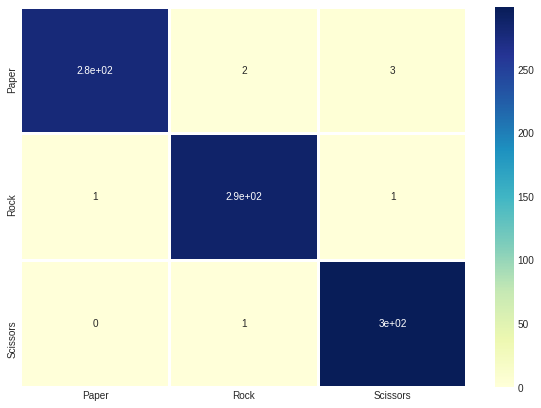

time: 29.1 s (started: 2021-07-27 09:33:04 +00:00)


In [20]:
# Confusion Matrix
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
matrix = confusion_matrix(val_generator.classes, y_pred)
df_cm = pd.DataFrame(matrix, index = ['Paper', 'Rock', 'Scissors'],
                  columns = ['Paper', 'Rock', 'Scissors'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, linewidths=2.5, cmap='YlGnBu')
plt.show()

In [21]:
# Classification Report
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(val_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       284
           1       0.99      0.99      0.99       290
           2       0.99      1.00      0.99       300

    accuracy                           0.99       874
   macro avg       0.99      0.99      0.99       874
weighted avg       0.99      0.99      0.99       874

time: 27.8 s (started: 2021-07-27 09:33:33 +00:00)


## Serving a vision model

Saving 2f25VA1nfxiC86xj.png to 2f25VA1nfxiC86xj.png
2f25VA1nfxiC86xj.png
Result : Yup, That's Rock


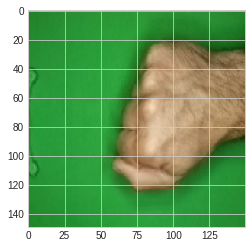

time: 57.3 s (started: 2021-07-27 09:34:01 +00:00)


In [22]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  predictionResult = model.predict(images, batch_size=10)

  print(fn)
  if predictionResult[0,0]!=0:
    print("Result : Yeah, It's Paper")
  elif predictionResult[0,1]!=0:
    print("Result : Yup, That's Rock")
  else:
    print("Result : You're right, that's Scissor")
